In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kepmodel.astro import AstroModel
from spleaf import term

In [2]:
# Load data
# We load here the data from csv files in a custom format (not representative of DR4).
# In particular, the data are already pre-filtered and transit-binned.
# We provide 7 files (target_1 to target_7).
gaia_data = pd.read_csv('C:\\Users\\casey\\UnigeMasters\\Astrophysics_and_Data_Analysis\\Databases\\target_4.csv')

In [3]:
gaia_data

,obs_time_tcb,centroid_pos_al,centroid_pos_error_al,parallax_factor_al,scan_pos_angle,field_of_view
0,2.457000e+06,65.642447,0.038256,-0.634377,-0.714604,2
1,2.457029e+06,-40.281306,0.025001,0.656136,-2.741825,1
2,2.457061e+06,9.531946,0.022807,-0.689496,-1.780655,1
3,2.457095e+06,-56.557312,0.020290,0.705878,2.378761,1
4,2.457120e+06,-52.499305,0.033024,-0.691414,-2.772801,1
...,...,...,...,...,...,...
60,2.458757e+06,-42.747652,0.026213,-0.709490,0.559285,1
61,2.458757e+06,-42.837764,0.029496,-0.710104,0.558979,2
62,2.458815e+06,-77.914361,0.028003,-0.644226,-0.503826,1
63,2.458852e+06,52.237079,0.025415,0.657165,-2.681583,1


In [4]:
# Initialize model
gaia_epoch_tcb = 2457936.875
cos_theta = np.cos(gaia_data.scan_pos_angle.values)
sin_theta = np.sin(gaia_data.scan_pos_angle.values)

# Create an "empty" model
model = AstroModel(
  gaia_data.obs_time_tcb.values - gaia_epoch_tcb,
  gaia_data.centroid_pos_al.values,
  cos_theta,
  sin_theta,
  err=term.Error(gaia_data.centroid_pos_error_al.values),
  excess_noise=term.Jitter(0),
)

# Add 5 basic linear parameters (parallax + position + proper-motion)
model.add_lin(gaia_data.parallax_factor_al.values, 'plx')
model.add_lin(cos_theta, 'delta')
model.add_lin(sin_theta, 'alpha')
delta_time_yr = (gaia_data.obs_time_tcb.values - gaia_epoch_tcb) / 365.25
model.add_lin(delta_time_yr * cos_theta, 'mu_delta')
model.add_lin(delta_time_yr * sin_theta, 'mu_alpha')

# Add scan-angle (odd) harmonics in the model
# max_harmonics = 0: no scan-angle harmonics modeling
# 3, 5, or 7: more and more complex modeling
max_harmonics = 0
for kharm in range(3, max_harmonics + 1, 2):
  model.add_lin(np.cos(kharm * gaia_data.scan_pos_angle.values), f'cos{kharm}theta')
  model.add_lin(np.sin(kharm * gaia_data.scan_pos_angle.values), f'sin{kharm}theta')

# Add acceleration/jerk
# max_degree_accel = 0: no-acceleration term
# max_degree_accel = 2: acceleration
# max_degree_accel = 3: acceleration + jerk
max_degree_accel = 0
for kdeg in range(2, max_degree_accel + 1):
  model.add_lin(delta_time_yr**kdeg * cos_theta, f'mu{kdeg}_delta')
  model.add_lin(delta_time_yr**kdeg * sin_theta, f'mu{kdeg}_alpha')

# Fit all linear parameters
model.fit_lin()
model.show_param()
print('log-likelihood:', model.loglike())
BIC = -2 * model.loglike() + len(model.fit_param) * np.log(model.n)
print('BIC:', BIC)

Parameter                        Value     Error       
lin.plx                       11.40880  ±  0.00508     
lin.delta                      0.00416  ±  0.00476     
lin.alpha                     -0.01380  ±  0.00491     
lin.mu_delta                 -26.35201  ±  0.00320     
lin.mu_alpha                  13.00024  ±  0.00341     
log-likelihood: -51.1101451052813
BIC: 123.09222656004079


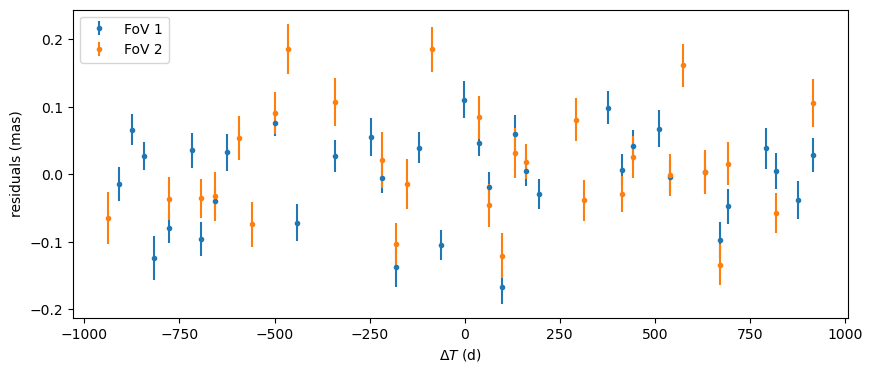

In [5]:
# Show residuals
residuals = model.residuals()
plt.figure(figsize=(10, 4))
for fov in range(1, 3):
  kfov = gaia_data.field_of_view == fov
  plt.errorbar(
    model.t[kfov],
    residuals[kfov],
    yerr=gaia_data.centroid_pos_error_al.values[kfov],
    fmt='.',
    label=f'FoV {fov}',
    rasterized=True,
  )
plt.xlabel('$\\Delta T$ (d)')
plt.ylabel('residuals (mas)')
plt.legend(loc='upper left')
plt.show()

In [6]:
# Adjust excess-noise (jitter)
model.fit_param += ['cov.excess_noise.sig']
model.fit()
model.show_param()
print('log-likelihood:', model.loglike())
BIC = -2 * model.loglike() + len(model.fit_param) * np.log(model.n)
print('BIC:', BIC)

Parameter                        Value     Error       
lin.plx                        11.4145  ±  0.0138      
lin.delta                       0.0023  ±  0.0130      
lin.alpha                      -0.0090  ±  0.0134      
lin.mu_delta                 -26.35300  ±  0.00862     
lin.mu_alpha                  12.99420  ±  0.00932     
cov.excess_noise.sig           0.06867  ±  0.00714     
log-likelihood: 76.26545069968768
BIC: -127.48457778000153


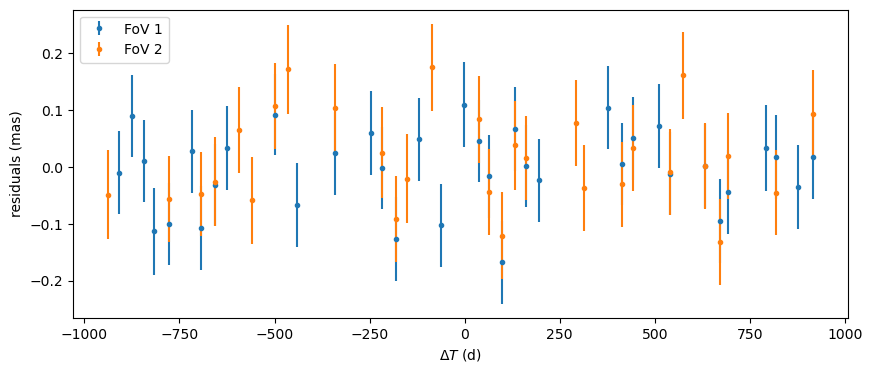

In [7]:
# Show residuals
residuals = model.residuals()
error_mas = np.sqrt(model.cov.A)  # errorbars incl. excess-noise
plt.figure(figsize=(10, 4))
for fov in range(1, 3):
  kfov = gaia_data.field_of_view == fov
  plt.errorbar(
    model.t[kfov],
    residuals[kfov],
    yerr=error_mas[kfov],
    fmt='.',
    label=f'FoV {fov}',
    rasterized=True,
  )
plt.xlabel('$\\Delta T$ (d)')
plt.ylabel('residuals (mas)')
plt.legend(loc='upper left')
plt.show()

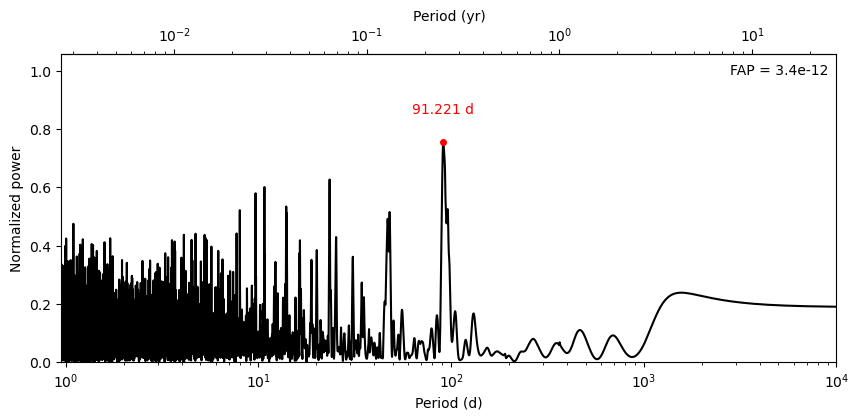

In [8]:
# Periodogram settings
Pmin = 0.95
Pmax = 10_000
nfreq = 50_000

# Compute periodogram
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)
nu, power = model.periodogram(nu0, dnu, nfreq)
P = 2 * np.pi / nu

# Compute FAP
kmax = np.argmax(power)
fap = model.fap(power[kmax], nu.max())

# Plot periodogram
plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.plot(P, power, 'k', lw=1.5, rasterized=True)
ax.plot(P[kmax], power[kmax], 'or', ms=4)
ax.set_xscale('log')
ax.set_xlim(Pmin, Pmax)
ax.set_ylim(0, 1.4 * power.max())
ax.set_ylabel('Normalized power')
ax.text(
  P[kmax],
  power[kmax] * 1.15,
  f'{P[kmax]:.3f} d',
  horizontalalignment='right'
  if P[kmax] > Pmax / 10
  else 'left'
  if P[kmax] < Pmin * 10
  else 'center',
  verticalalignment='center',
  color='r',
)
ax.text(
  0.99,
  0.97,
  f'FAP = {fap:.2g}',
  transform=ax.transAxes,
  horizontalalignment='right',
  verticalalignment='top',
)
ax.set_xlabel('Period (d)')
ax2 = ax.secondary_xaxis('top', functions=(lambda x: x / 365.25, lambda x: x / 365.25))
ax2.set_xlabel('Period (yr)')
plt.show()

Targets:

1: FAP=2.9e-38, P=1775.810, BIC(5L+J)=-285.1734831183885 

2: FAP=1 (ALARMMMMM), P=1.406, BIC(5L+J)=-277.96451362174435

3: FAP=1.8e-3, P=1711.818, BIC(5L+J)=-137.48266078169536

4: FAP=3.4e-12, P=91.221, BIC(5L+J)=-201.05168180515437

5: FAP=4.1e-21, P=90.872, BIC(5L+J)=-212.81628756176931

6: FAP=4.1e-4, P=88.667, BIC(5L+J)=-271.0608304220151

7: FAP=3e-40, P=5428.758, BIC(5L+J)=-142.58440405026246


In [9]:
# Add the planet in the model
model.add_keplerian_from_period(P[kmax], name='b')
model.fit()
model.show_param()
print('log-likelihood:', model.loglike())
BIC = -2 * model.loglike() + len(model.fit_param) * np.log(model.n)
print('BIC:', BIC)

Parameter                        Value     Error       
lin.plx                       11.41156  ±  0.00678     
lin.delta                       0.0158  ±  0.0190      
lin.alpha                      -0.0008  ±  0.0291      
lin.mu_delta                 -26.36686  ±  0.00516     
lin.mu_alpha                  12.98736  ±  0.00683     
cov.excess_noise.sig           0.01766  ±  0.00551     
kep.b.P                         91.150  ±  0.348       
kep.b.M0 [deg]                   284.6  ±  21.4        
kep.b.e                          0.483  ±  0.156       
kep.b.TIA                       0.0224  ±  0.0214      
kep.b.TIB                       0.0096  ±  0.0434      
kep.b.TIF                       0.0477  ±  0.0147      
kep.b.TIG                      -0.1415  ±  0.0169      
log-likelihood: 127.65935815689883
BIC: -201.05168180515437


In [10]:
# Change the set of orbital parameters
model.set_keplerian_param('b', ['P', 'as', 'M0', 'e', 'varpi', 'i', 'bigomega'])
model.fit()
model.show_param()
print('log-likelihood:', model.loglike())
BIC = -2 * model.loglike() + len(model.fit_param) * np.log(model.n)
print('BIC:', BIC)

Parameter                        Value     Error       
lin.plx                       11.41156  ±  0.00678     
lin.delta                       0.0158  ±  0.0190      
lin.alpha                      -0.0008  ±  0.0291      
lin.mu_delta                 -26.36686  ±  0.00516     
lin.mu_alpha                  12.98736  ±  0.00683     
cov.excess_noise.sig           0.01766  ±  0.00551     
kep.b.P                         91.150  ±  0.348       
kep.b.as                        0.1493  ±  0.0163      
kep.b.M0 [deg]                   284.6  ±  21.4        
kep.b.e                          0.483  ±  0.156       
kep.b.varpi [deg]                197.8  ±  17.1        
kep.b.i [deg]                    99.37  ±  4.61        
kep.b.bigomega [deg]            108.50  ±  4.35        
log-likelihood: 127.6593581878027
BIC: -201.0516818669621


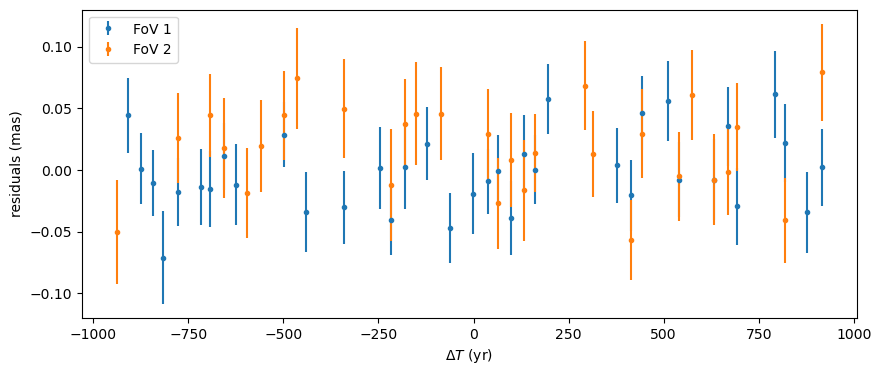

In [11]:
# Show residuals
residuals = model.residuals()
error_mas = np.sqrt(model.cov.A)  # errorbars incl. excess-noise
plt.figure(figsize=(10, 4))
for fov in range(1, 3):
  kfov = gaia_data.field_of_view == fov
  plt.errorbar(
    model.t[kfov],
    residuals[kfov],
    yerr=error_mas[kfov],
    fmt='.',
    label=f'FoV {fov}',
    rasterized=True,
  )
plt.xlabel('$\\Delta T$ (yr)')
plt.ylabel('residuals (mas)')
plt.legend(loc='upper left')
plt.show()

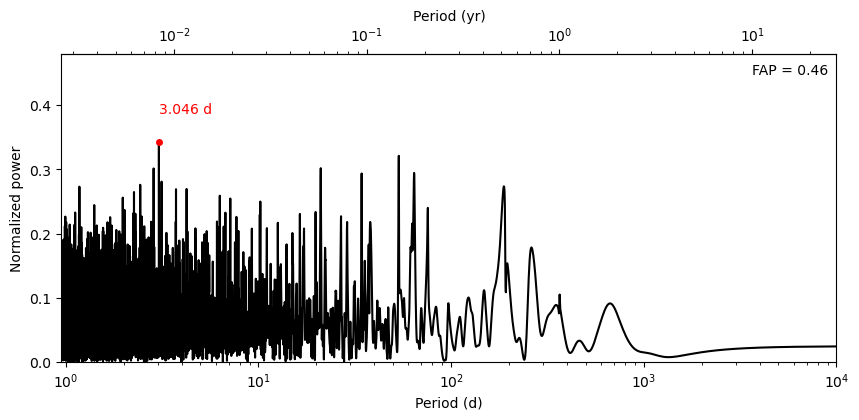

In [12]:
# Compute periodogram of residuals
nu, power = model.periodogram(nu0, dnu, nfreq)

# Compute FAP
kmax = np.argmax(power)
fap = model.fap(power[kmax], nu.max())

# Plot periodogram
plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.plot(P, power, 'k', lw=1.5, rasterized=True)
ax.plot(P[kmax], power[kmax], 'or', ms=4)
ax.set_xscale('log')
ax.set_xlim(Pmin, Pmax)
ax.set_ylim(0, 1.4 * power.max())
ax.set_ylabel('Normalized power')
ax.text(
  P[kmax],
  power[kmax] * 1.15,
  f'{P[kmax]:.3f} d',
  horizontalalignment='right'
  if P[kmax] > Pmax / 10
  else 'left'
  if P[kmax] < Pmin * 10
  else 'center',
  verticalalignment='center',
  color='r',
)
ax.text(
  0.99,
  0.97,
  f'FAP = {fap:.2g}',
  transform=ax.transAxes,
  horizontalalignment='right',
  verticalalignment='top',
)
ax.set_xlabel('Period (d)')
ax2 = ax.secondary_xaxis('top', functions=(lambda x: x / 365.25, lambda x: x / 365.25))
ax2.set_xlabel('Period (yr)')
plt.show()

In [13]:
# Compute the companion's mass-function and mass (assuming a solar mass for the primary)
plx_mas, P_d, a_mas = model.get_param(['lin.plx', 'kep.b.P', 'kep.b.as'])
P_yr = P_d/365.25
a_AU = a_mas / plx_mas
n_rad_yr = 2 * np.pi / P_yr
GmSun_AU3yr2 = 39.47692640889763
mass_function = n_rad_yr**2 * a_AU**3 / GmSun_AU3yr2
print('mass_function = m_b**3/(m_s+m_b)**2 =', mass_function)

m_s = 1  # solar mass
m_b = 0
for _ in range(50):
  m_b = (mass_function * (m_s + m_b) ** 2) ** (1 / 3)
m_b *= 1047.5655146604774  # convert to Jupiter mass
print('m_b (m_Jup) =', m_b)

mass_function = m_b**3/(m_s+m_b)**2 = 3.596375038817327e-05
m_b (m_Jup) = 35.35186014934969


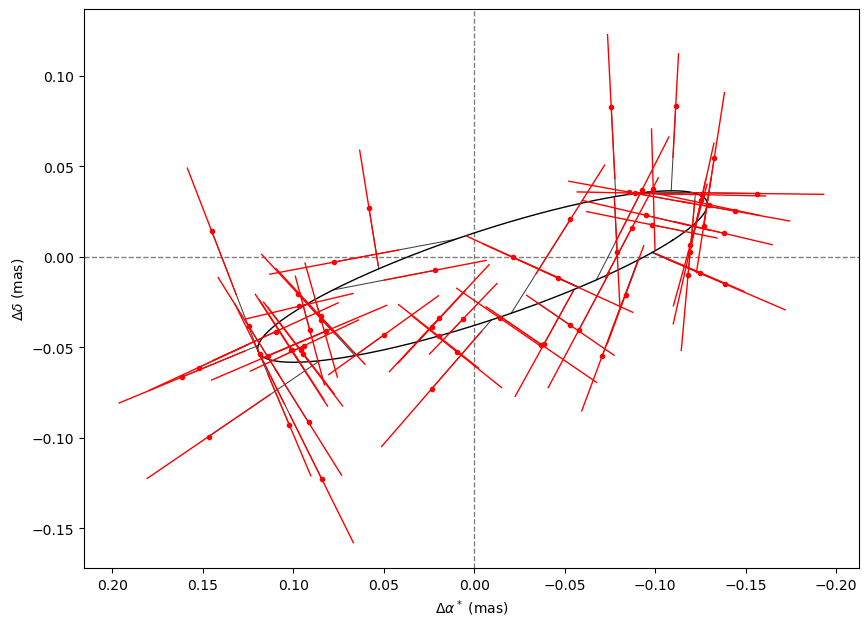

In [14]:
# Plot the orbit
# Compute smooth Keplerian model
Pb = model.get_param('kep.b.P')
t_smooth = np.linspace(-Pb / 2, Pb / 2, 1000)
delta_keplerian_smooth, alpha_keplerian_smooth = model.keplerian['b'].astro(t_smooth)

# Compute residuals projected on orbit
delta_keplerian, alpha_keplerian = model.keplerian['b'].astro(model.t)
residuals = model.residuals()
error_mas = np.sqrt(model.cov.A)  # errorbars incl. excess-noise

delta_res = delta_keplerian + residuals * cos_theta
alpha_res = alpha_keplerian + residuals * sin_theta
delta_err = error_mas * cos_theta
alpha_err = error_mas * sin_theta

plt.figure(figsize=(10, 10))
for k in range(len(residuals)):
  plt.plot(
    [alpha_res[k], alpha_keplerian[k]],
    [delta_res[k], delta_keplerian[k]],
    'k',
    lw=0.75,
    alpha=0.75,
    zorder=0,
  )
for k in range(len(residuals)):
  plt.plot(
    [alpha_res[k] - alpha_err[k], alpha_res[k] + alpha_err[k]],
    [delta_res[k] - delta_err[k], delta_res[k] + delta_err[k]],
    'r-',
    lw=1,
    zorder=2,
  )
plt.plot(
  alpha_keplerian_smooth, delta_keplerian_smooth, 'k-', lw=1, rasterized=True, zorder=1
)
plt.plot(alpha_res, delta_res, 'r.', rasterized=True, zorder=3)
plt.xlabel('$\\Delta \\alpha^*$ (mas)')
plt.ylabel('$\\Delta \\delta$ (mas)')
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(xlim, [0, 0], '--', c='gray', lw=1, zorder=-10)
plt.plot([0, 0], ylim, '--', c='gray', lw=1, zorder=-10)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [15]:
# Run an MCMC
from samsam import sam, logprior
from corner import corner

In [16]:
nsamples = 100_000


# Define priors
def logprior_sin(x):
  assert (x > 0) & (x < np.pi)
  return np.log(np.sin(x))


prior_dict = {
  'lin.plx': lambda x: logprior.uniform(x, 0, 1000),
  'lin.delta': lambda x: logprior.uniform(x, -100, 100),
  'lin.alpha': lambda x: logprior.uniform(x, -100, 100),
  'lin.mu_delta': lambda x: logprior.uniform(x, -1e5, 1e5),
  'lin.mu_alpha': lambda x: logprior.uniform(x, -1e5, 1e5),
  'cov.excess_noise.sig': lambda x: logprior.truncnormal(x, 0, 1.0),
  'kep.b.P': lambda x: logprior.loguniform(x, 0, np.log(1e5)),
  'kep.b.as': lambda x: logprior.loguniform(x, np.log(1e-4), np.log(1e2)),
  'kep.b.la0': lambda x: -np.log(2 * np.pi),
  'kep.b.M0': lambda x: -np.log(2 * np.pi),
  'kep.b.Marg0': lambda x: -np.log(2 * np.pi),
  'kep.b.e': lambda x: logprior.uniform(x, 0, 1),
  'kep.b.varpi': lambda x: -np.log(2 * np.pi),
  'kep.b.i': logprior_sin,
  'kep.b.bigomega': lambda x: -np.log(2 * np.pi),
}

lprior_funcs = [prior_dict[key] for key in model.fit_param]


def lprior(x):
  return sum(lpk(xk) for lpk, xk in zip(lprior_funcs, x))


def lprob(x):
  try:
    lp = lprior(x)
    assert np.isfinite(lp)
    ll = model.loglike(x)
    assert np.isfinite(ll)
    return lp + ll
  except (ValueError, ZeroDivisionError, AssertionError, logprior.OutOfBoundsError):
    return -np.inf


# Launch MCMC
x0 = model.get_param()
samples, diags = sam(x0, lprob, nsamples)

samples_deg = samples.copy()
for k in [
  model.fit_param.index(key)
  for key in [
    'kep.b.la0',
    'kep.b.M0',
    'kep.b.Marg0',
    'kep.b.varpi',
    'kep.b.i',
    'kep.b.bigomega',
  ]
  if key in model.fit_param
]:
  samples_deg[:, k] = (samples_deg[:, k] * 180 / np.pi) % 360

Step 100000, acceptance rate (since last printing): 0.1720 


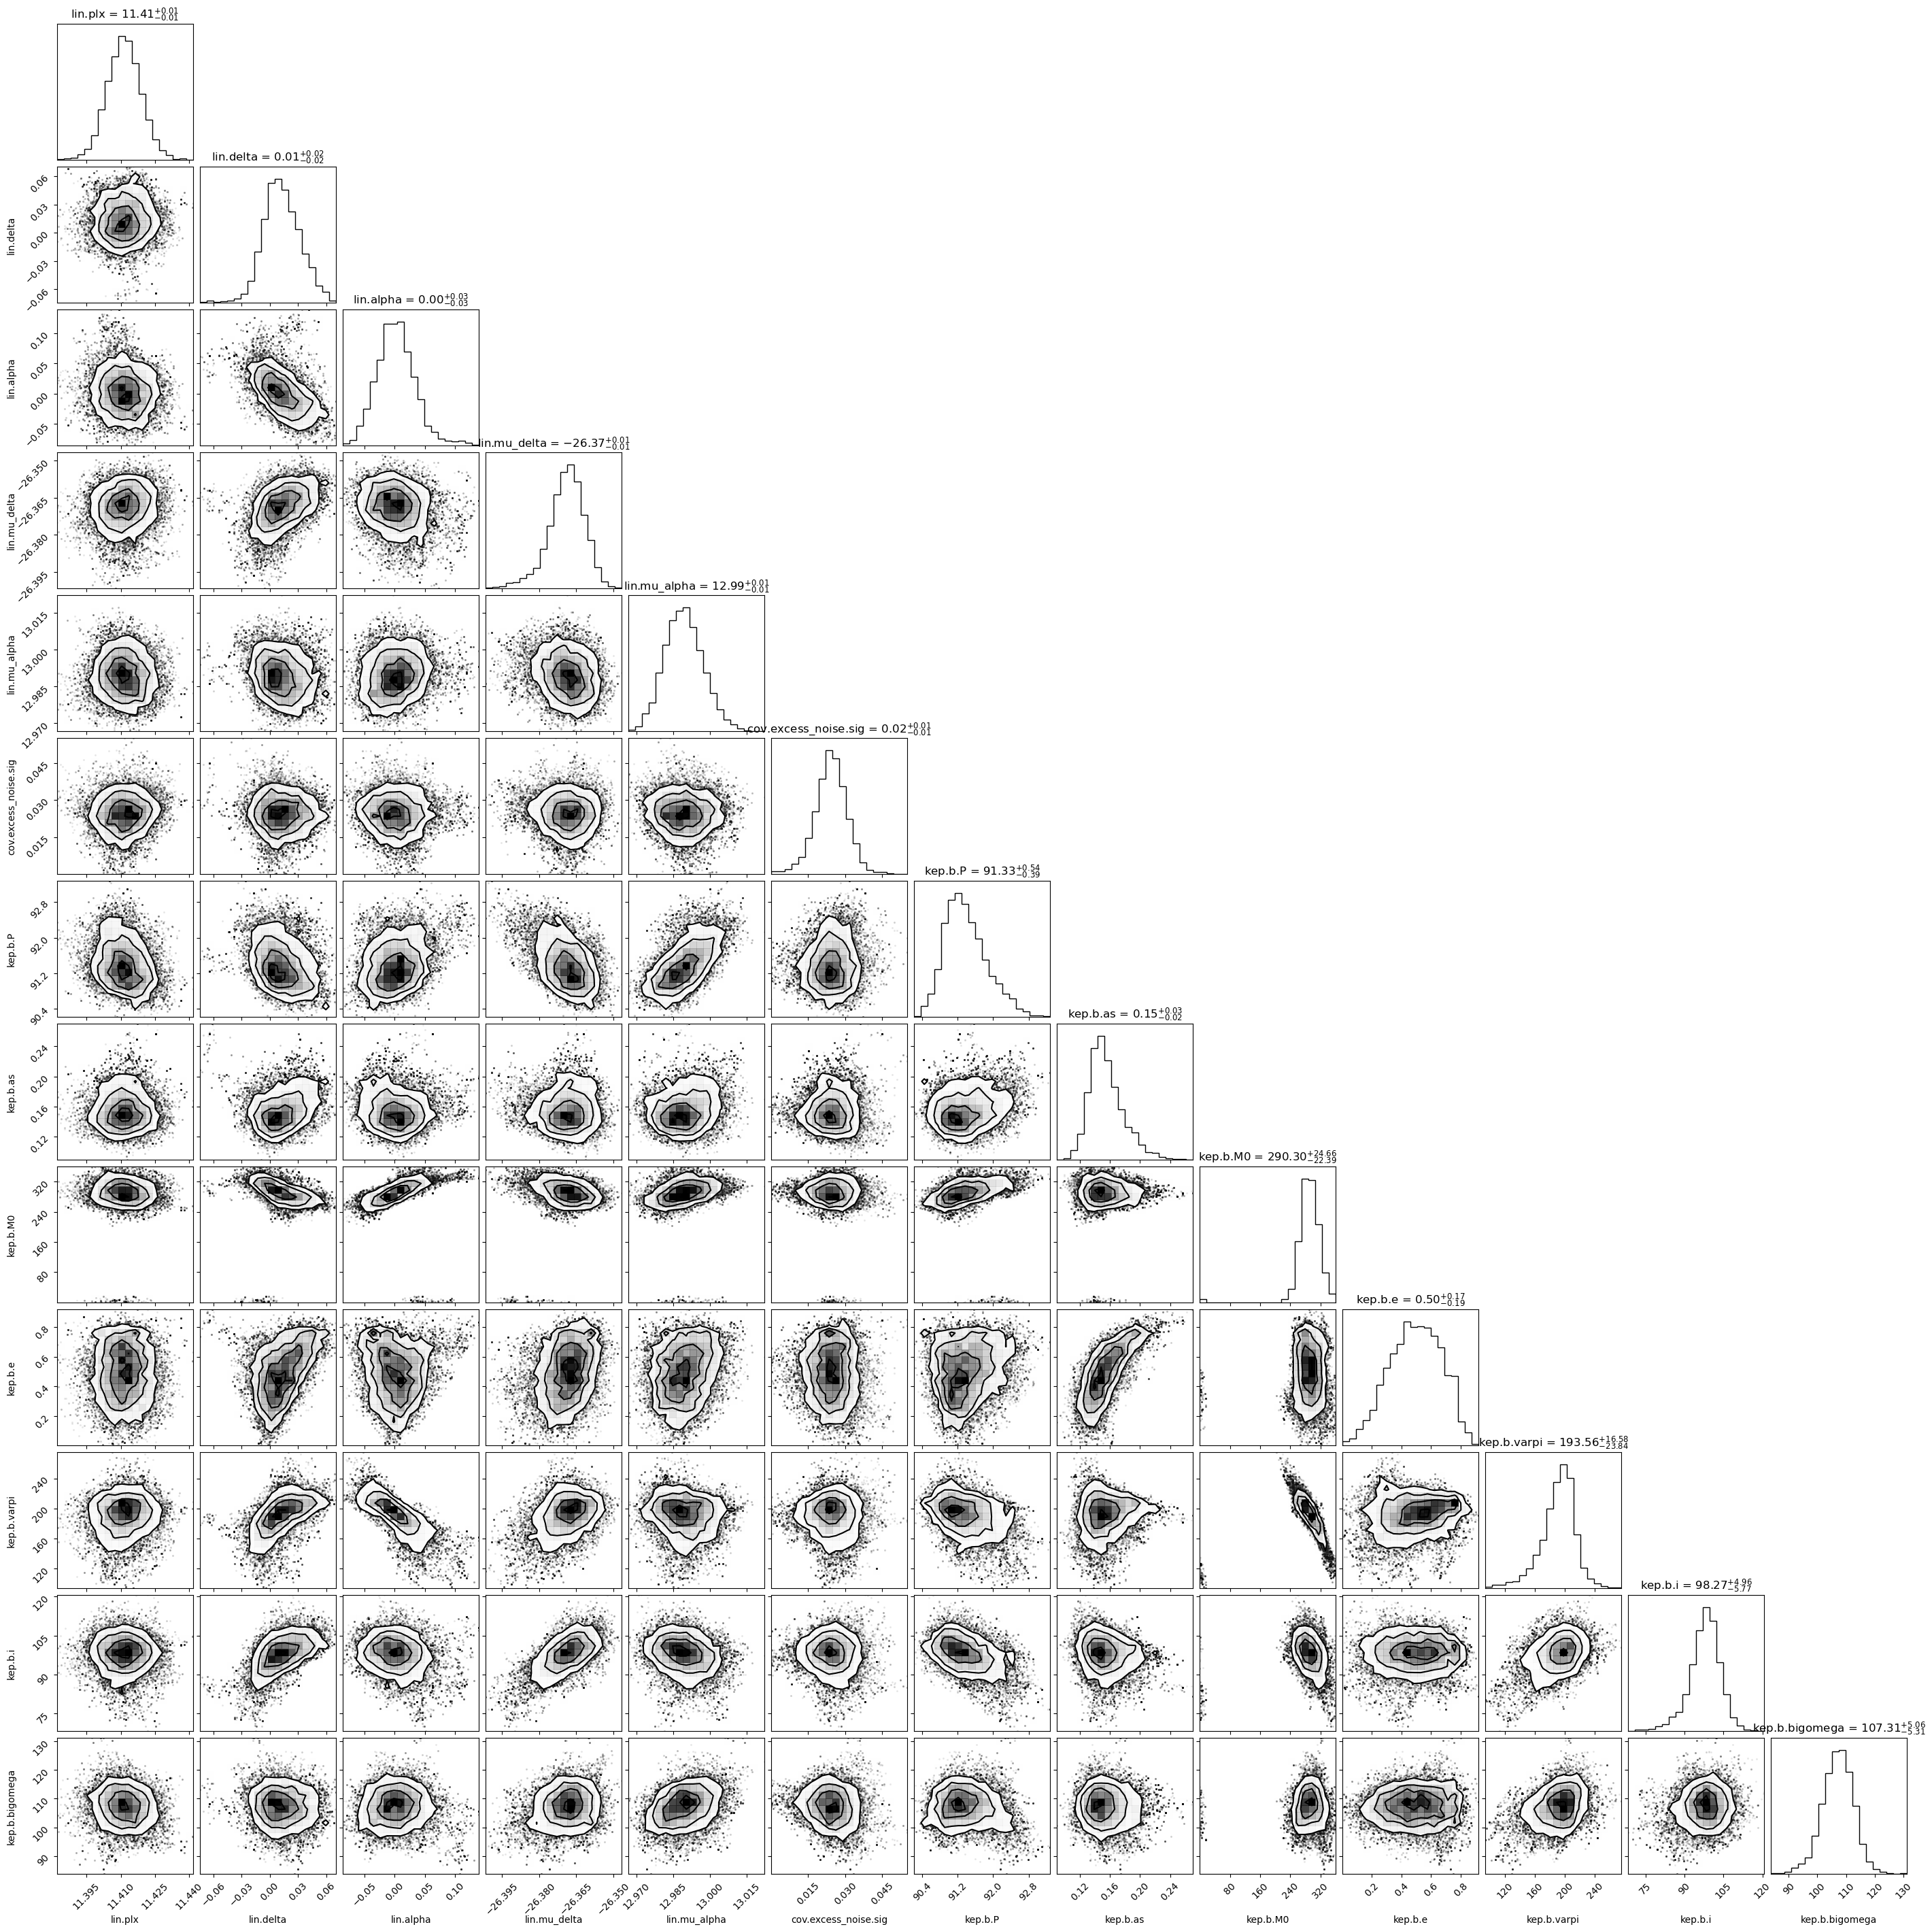

In [17]:
# Corner plot
corner(samples_deg[nsamples // 2 :], labels=model.fit_param, show_titles=True)
plt.show()